In [2]:
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2

/home/xabush/moses-incons-pen-xp
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from notebooks.manifold_reg.util import *
from notebooks.manifold_reg.grad_util import *
from sklearn.model_selection import train_test_split, KFold
from autograd import elementwise_grad as egrad
import scipy

In [4]:
def assign_cols(X):
    cols = []
    for i in range(1, X.shape[1]):
        cols.append(f"{i}")
    cols.append("y")
    X.columns = cols

In [5]:
data_df = pd.read_csv("data/data_bm.csv")
data_df.shape

(100, 1001)

In [6]:
data_df

,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,...,g992,g993,g994,g995,g996,g997,g998,g999,g1000,y
0,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,0,0,0,0,0,0
1,1,1,1,1,1,1,0,0,1,1,...,0,0,1,0,0,1,0,1,0,0
2,1,1,1,1,1,1,0,0,1,1,...,0,0,1,0,0,0,1,1,0,1
3,1,1,0,1,1,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
4,1,1,0,1,1,1,0,1,1,1,...,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,0,1,1,1,0,1,1,1,...,0,1,1,0,0,0,1,1,0,0
96,1,1,1,1,1,1,0,0,1,1,...,0,0,1,0,0,1,0,1,0,0
97,1,0,1,1,1,1,0,0,1,1,...,1,1,1,0,0,1,1,1,0,0
98,1,1,0,1,1,1,0,1,1,1,...,1,1,1,0,0,0,1,1,0,0


In [203]:
assign_cols(data_df)

In [6]:
net_df = pd.read_csv("data/feat_net.csv", header=None)

In [7]:
np.count_nonzero(net_df.to_numpy())

329034

In [1088]:
assoc_mat = net_df.to_numpy()
np.fill_diagonal(assoc_mat, 1.0)
assoc_mat = np.abs(assoc_mat)
assoc_mat_2 = np.copy(assoc_mat)
assoc_mat_2[assoc_mat_2 > 0.0] = 1.0

In [1231]:
assoc_mat_3 = net_df.to_numpy()
np.fill_diagonal(assoc_mat_3, 1.0)
assoc_mat_3

array([[ 1.     ,  0.     , -1.3997 , ...,  1.     ,  0.     ,  0.     ],
       [ 0.     ,  1.     ,  0.     , ...,  0.     , -1.4212 ,  0.     ],
       [-1.3997 ,  0.     ,  1.     , ...,  0.     ,  0.     , -0.17373],
       ...,
       [ 1.     ,  0.     ,  0.     , ...,  1.     ,  0.     ,  0.     ],
       [ 0.     , -1.4212 ,  0.     , ...,  0.     ,  1.     , -1.1482 ],
       [ 0.     ,  0.     , -0.17373, ...,  0.     , -1.1482 ,  1.     ]])

In [1226]:
np.save("data/bmm/feat_net.npy", assoc_mat)
np.save("data/bmm/feat_net_bin.npy", assoc_mat_2)

In [9]:
X, y = data_df.iloc[:,:-1].to_numpy(), data_df.iloc[:,-1:].to_numpy()
X.shape

(100, 1000)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.3)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [940]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(data_df.iloc[:,:-1], data_df.iloc[:,-1:], random_state=42, stratify=data_df.iloc[:,-1:], shuffle=True, test_size=0.3)
X_train_df.columns = [f"f{i}" for i in range(X_train_df.shape[1])]
X_test_df.columns = [f"f{i}" for i in range(X_test_df.shape[1])]
y_train_df.columns = ["y"]
y_test_df.columns = ["y"]
df_train = pd.concat([X_train_df, y_train_df], axis=1)
df_test = pd.concat([X_test_df, y_test_df], axis=1)
df_train.to_csv("data/bmm/data_train.csv", index=False)
df_test.to_csv("data/bmm/data_test.csv", index=False)

In [12]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([21,  9]))

In [1203]:
gammas = np.logspace(-2, 3, 10)
gammas

array([1.00000000e-02, 3.59381366e-02, 1.29154967e-01, 4.64158883e-01,
       1.66810054e+00, 5.99484250e+00, 2.15443469e+01, 7.74263683e+01,
       2.78255940e+02, 1.00000000e+03])

In [13]:
cov_mat = np.cov(X_train, rowvar=False)
cov_mat

array([[ 1.42857143e-02, -4.14078675e-04,  5.59006211e-03, ...,
        -8.69565217e-03,  1.20082816e-02,  2.07039337e-04],
       [-4.14078675e-04,  2.81573499e-02, -1.78053830e-02, ...,
        -1.73913043e-02, -4.96894410e-03,  4.14078675e-04],
       [ 5.59006211e-03, -1.78053830e-02,  2.40372671e-01, ...,
        -5.50724638e-02, -1.98757764e-02,  8.90269151e-03],
       ...,
       [-8.69565217e-03, -1.73913043e-02, -5.50724638e-02, ...,
         2.43478261e-01, -2.89855072e-03, -5.79710145e-03],
       [ 1.20082816e-02, -4.96894410e-03, -1.98757764e-02, ...,
        -2.89855072e-03,  1.44099379e-01, -1.20082816e-02],
       [ 2.07039337e-04,  4.14078675e-04,  8.90269151e-03, ...,
        -5.79710145e-03, -1.20082816e-02,  1.42857143e-02]])

In [14]:
l, u = np.linalg.eigh(cov_mat)
l = np.flip(l)
u = np.flip(u, axis=1)

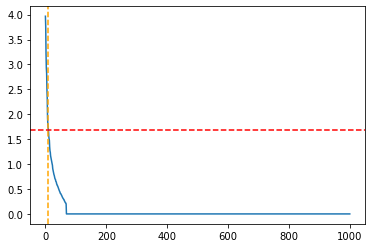

In [483]:
p = 10
plt.plot(np.arange(l.shape[0]), l)
plt.axvline(x=p, color="orange", linestyle="--")
plt.axhline(y=l[p], color="red", linestyle="--")

In [110]:
from notebooks.manifold_reg.util import get_psd_mat
l_p = l[:35]
u_p = u[:35]
l_p_inv = np.diag(1.0/(l_p))
cov_inv = u_p.T @ l_p_inv @ u_p
cov_inv = get_psd_mat((assoc_mat * cov_inv))
K_train = calculate_mahal_kernel(X_train, X_train, cov_inv, 1)
K_test = calculate_mahal_kernel(X_test, X_train, cov_inv, 1)
K_train_idt = calculate_mahal_kernel(X_train, X_train, np.identity(X_train.shape[1]), 1)
K_test_idt = calculate_mahal_kernel(X_test, X_train, np.identity(X_train.shape[1]), 1)

In [522]:
from notebooks.manifold_reg.util import *
train_errs_mahal_auc_0, train_errs_mahal_ll_0, test_errs_mahal_auc_0, test_errs_mahal_ll_0, \
               train_errs_idt_auc_0, train_errs_idt_ll_0, test_errs_idt_auc_0, test_errs_idt_ll_0 = compare_kernels_log(gammas, X_train, X_test, y_train, y_test, cv_fold=5, random_state=42)

Num iter: 0
gamma - 0.01
Num iter: 0
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
Num iter: 0
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
Num iter: 0
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_st

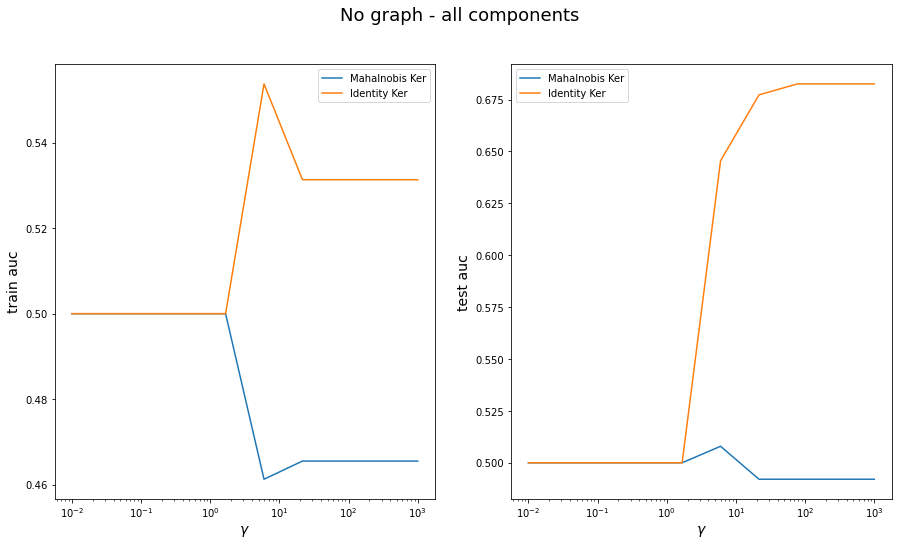

In [526]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("No graph - all components", fontsize=18)
ax[0].plot(gammas, train_errs_mahal_auc_0, label="Mahalnobis Ker")
ax[0].plot(gammas, train_errs_idt_auc_0, label="Identity Ker")
ax[0].set_xscale("log")
ax[1].plot(gammas, test_errs_mahal_auc_0, label="Mahalnobis Ker")
ax[1].plot(gammas, test_errs_idt_auc_0, label="Identity Ker")
ax[1].set_xscale("log")
ax[0].set_xlabel("$\gamma$", fontsize=14)
ax[1].set_xlabel("$\gamma$", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[0].legend()
ax[1].legend()

In [440]:
train_errs_mahal_auc, train_errs_mahal_ll, test_errs_mahal_auc, test_errs_mahal_ll, \
               train_errs_idt_auc, train_errs_idt_ll, test_errs_idt_auc, test_errs_idt_ll = compare_kernels_log(gammas, X_train, X_test, y_train, y_test, assoc_mat, cv_fold=5, random_state=42)

Num iter: 9
gamma - 0.01
Num iter: 9
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
Num iter: 9
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
Num iter: 9
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_steps=0
relative change below tolerance; stopping after 1 epochs
epoch 0, delta=0.00000, rel_change=0.00000, ls_steps=0
epoch 1, delta=0.00000, rel_change=0.00000, ls_st

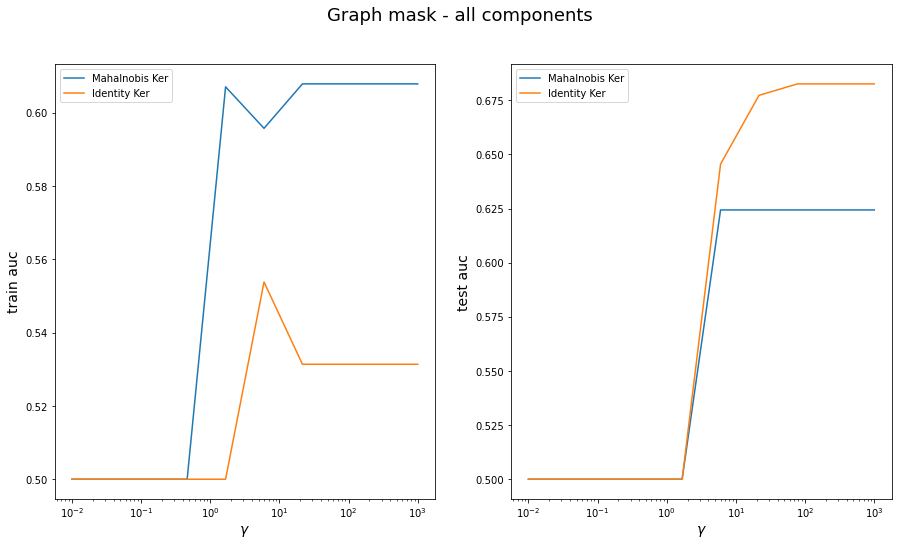

In [527]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("Graph mask - all components", fontsize=18)
ax[0].plot(gammas, train_errs_mahal_auc, label="Mahalnobis Ker")
ax[0].plot(gammas, train_errs_idt_auc, label="Identity Ker")
ax[0].set_xscale("log")
ax[1].plot(gammas, test_errs_mahal_auc, label="Mahalnobis Ker")
ax[1].plot(gammas, test_errs_idt_auc, label="Identity Ker")
ax[1].set_xscale("log")
ax[0].set_xlabel("$\gamma$", fontsize=14)
ax[1].set_xlabel("$\gamma$", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[0].legend()
ax[1].legend()

In [107]:
from notebooks.manifold_reg.util import compare_kernels_log
train_errs_mahal_auc_2, train_errs_mahal_ll_2, test_errs_mahal_auc_2, test_errs_mahal_ll_2, \
               train_errs_idt_auc_2, train_errs_idt_ll_2, test_errs_idt_auc_2, test_errs_idt_ll_2 = compare_kernels_log(gammas, X_train, X_test, y_train, y_test, None, cv_fold=5, random_state=42, n_component=35)

gamma - 0.01
gamma - 0.04
gamma - 0.13
gamma - 0.46
gamma - 1.67
gamma - 5.99
gamma - 21.54
gamma - 77.43
gamma - 278.26
gamma - 1000.00
Done


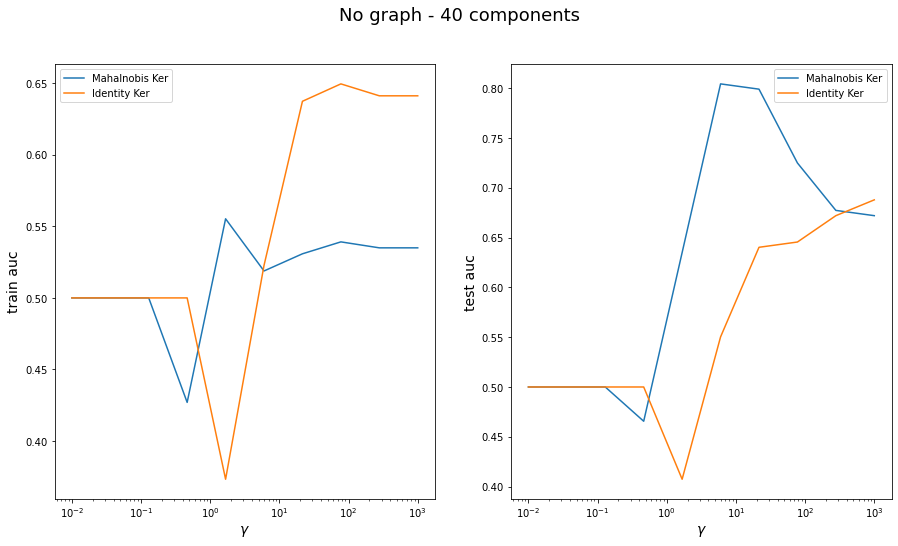

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("No graph - 40 components", fontsize=18)
ax[0].plot(gammas, train_errs_mahal_auc_2, label="Mahalnobis Ker")
ax[0].plot(gammas, train_errs_idt_auc_2, label="Identity Ker")
ax[0].set_xscale("log")
ax[1].plot(gammas, test_errs_mahal_auc_2, label="Mahalnobis Ker")
ax[1].plot(gammas, test_errs_idt_auc_2, label="Identity Ker")
ax[1].set_xscale("log")
ax[0].set_xlabel("$\gamma$", fontsize=14)
ax[1].set_xlabel("$\gamma$", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[0].legend()
ax[1].legend()

In [109]:
test_errs_mahal_auc_2

array([0.5       , 0.5       , 0.5       , 0.46560847, 0.63492063,
       0.8042328 , 0.7989418 , 0.72486772, 0.67724868, 0.67195767])

In [152]:
from notebooks.manifold_reg.util import compare_kernels_log
train_errs_mahal_auc_3, train_errs_mahal_ll_3, test_errs_mahal_auc_3, test_errs_mahal_ll_3, \
               train_errs_idt_auc_3, train_errs_idt_ll_3, test_errs_idt_auc_3, test_errs_idt_ll_3 = compare_kernels_log(gammas, X_train, X_test, y_train, y_test, assoc_mat, cv_fold=5, random_state=42, n_component=36)

gamma - 0.01
gamma - 0.04
gamma - 0.13
gamma - 0.46
gamma - 1.67
gamma - 5.99
gamma - 21.54
gamma - 77.43
gamma - 278.26
gamma - 1000.00
Done


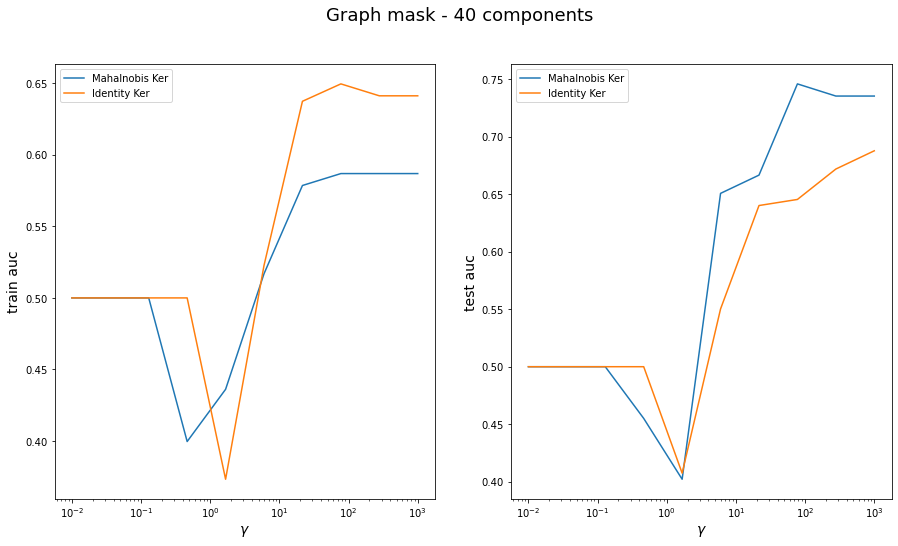

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("Graph mask - 40 components", fontsize=18)
ax[0].plot(gammas, train_errs_mahal_auc_3, label="Mahalnobis Ker")
ax[0].plot(gammas, train_errs_idt_auc_3, label="Identity Ker")
ax[0].set_xscale("log")
ax[1].plot(gammas, test_errs_mahal_auc_3, label="Mahalnobis Ker")
ax[1].plot(gammas, test_errs_idt_auc_3, label="Identity Ker")
ax[1].set_xscale("log")
ax[0].set_xlabel("$\gamma$", fontsize=14)
ax[1].set_xlabel("$\gamma$", fontsize=14)
ax[0].set_ylabel("train auc", fontsize=14)
ax[1].set_ylabel("test auc", fontsize=14)
ax[0].legend()
ax[1].legend()

In [155]:
weights = np.zeros(len(y_train))
test_errs_mahal_auc_3

array([0.5       , 0.5       , 0.5       , 0.45502646, 0.4021164 ,
       0.65079365, 0.66666667, 0.74603175, 0.73544974, 0.73544974])

In [126]:
def log_likelihood(b, X, y):
    f = X @ b
    ll = np.sum((y * f) - np.log(1 + np.exp(f)))
    return ll
def bic(b, X, y, p):
    y_c = y.copy()
    y_c[y_c == 0] = -1
    ll = log_likelihood(b, X, y)
    d = X.shape[1] - p
    # print(f"ll: {ll}")
    return -2*ll + p*np.log(np.log(X.shape[0]))

def aic(b, X, y, p):
    ll = log_likelihood(b, X, y)
    # print(f"ll - {ll}")
    # d = X.shape[1] - p
    return -2*ll + 2*p

In [1207]:
from notebooks.manifold_reg.util import get_psd_mat_2, KernelLogisiticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import pairwise_distances
import traceback
def select_n_components_0(X, y, assoc_mat=None):
    n_dims = np.arange(1, 101)
    n_samples = X.shape[0]
    bic_scores = np.zeros(len(n_dims))
    aic_scores = np.zeros(len(n_dims))
    d = X.shape[1]
    for i, p in enumerate(n_dims):
        try:
            clf = KernelLogisiticRegression(n_components=p, gamma=0.01, assoc_mat=assoc_mat).fit(X, y)
            ll = log_likelihood(clf.coef_[0],  clf.K_, y)
            # y_pred = clf.predict_proba(K)[:,1]
            # bic_s = -2*ll + 0.5*((p*(p + 1)))*np.log(n_samples)
            # aic_s = -2*ll + (p*(p + 1))
            bic_s = -2*ll + (d - 1)*(p-1)*np.log(n_samples)
            aic_s = -2*ll + 2*(d - 1)*(p-1)
            bic_scores[i] = bic_s
            aic_scores[i] = aic_s
            print(f"p : {p}, bic: {bic_s}, aic: {aic_s}, ll: {ll}")
        except ValueError as e:
            print(f"Skipping {p}")
            bic_scores[i] = 1e6
            aic_scores[i] = 1e6

    return bic_scores, aic_scores

def calculate_acc_var(l, n):
    ls = []
    for i in n:
        ls.append(np.round((np.sum(l[:i])/np.sum(l)), 3))
    return ls

In [1208]:
import warnings
warnings.filterwarnings("ignore")
bic_scores, aic_scores = select_n_components_0(X_train, y_train, assoc_mat)

Skipping 1
p : 2, bic: 4244.265984147496, aic: 1998.0192373401858, ll: -0.009618670092911105
p : 3, bic: 8488.512730954806, aic: 3996.019237340186, ll: -0.009618670092911105
p : 4, bic: 12732.759477762116, aic: 5994.019237340186, ll: -0.009618670092911105
p : 5, bic: 16977.006224569424, aic: 7992.019237340186, ll: -0.009618670092911105
p : 6, bic: 21221.252971376733, aic: 9990.019237340186, ll: -0.009618670092911105
p : 7, bic: 25465.499718184044, aic: 11988.019237340186, ll: -0.009618670092911105
p : 8, bic: 29709.746464991353, aic: 13986.019237340186, ll: -0.009618670092911105
p : 9, bic: 33953.99321179867, aic: 15984.019237340186, ll: -0.009618670092911105
p : 10, bic: 38198.23995860598, aic: 17982.019237340184, ll: -0.009618670092911105
p : 11, bic: 42442.486705413285, aic: 19980.019237340184, ll: -0.009618670092911105
p : 12, bic: 46686.7334522206, aic: 21978.019237340184, ll: -0.009618670092911105
p : 13, bic: 50930.98019902791, aic: 23976.019237340184, ll: -0.009618670092911105


KeyboardInterrupt: 

In [1197]:
np.argmin(aic_scores)

5

In [503]:
def plot_ker_scores(gammas, train_1, train_2, test_1, test_2, title=""):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(title)
    ax[0].plot(gammas, train_1, label="Mahalnobis Ker")
    ax[0].plot(gammas, train_2, label="Identity Ker")
    ax[0].set_xscale("log")
    ax[1].plot(gammas, test_1, label="Mahalnobis Ker")
    ax[1].plot(gammas, test_2, label="Identity Ker")
    ax[1].set_xscale("log")
    ax[0].set_xlabel("$\gamma$", fontsize=14)
    ax[1].set_xlabel("$\gamma$", fontsize=14)
    ax[0].set_ylabel("train auc", fontsize=14)
    ax[1].set_ylabel("test auc", fontsize=14)
    ax[0].legend()
    ax[1].legend()

In [452]:
from sklearn.covariance import ShrunkCovariance
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import pairwise_distances

def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages}, verbose=2, n_jobs=-1).fit(X)
    return cv.best_estimator_, np.mean(cross_val_score(cv.best_estimator_, X))

In [442]:
scv, score = shrunk_cov_score(X_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [738]:
np.argmin(bic_scores)

0

In [485]:
pairwise_distances(X_test, X_train, metric="mahalanobis",  VI=scv.precision_).shape

(30, 70)

In [49]:
from notebooks.manifold_reg.util import get_psd_mat, compare_kernels_log
def select_n_components():
    n_dims = np.arange(1, X_train.shape[0] + 1)
    train_auc_scores = np.zeros((2, len(n_dims), len(gammas)))
    test_auc_scores = np.zeros((2, len(n_dims), len(gammas)))
    for p in n_dims:
        try:
            train_auc_scores[0, p], _, test_auc_scores[0, p], _, \
                   train_auc_scores[1, p], _, test_auc_scores[1, p], _ = compare_kernels_log(gammas, X_train, X_test, y_train, y_test, assoc_mat, cv_fold=5, random_state=42, n_component=p, verbose=0)
        except:
            print(f"skipping - {p}")
    return train_auc_scores, test_auc_scores

In [664]:
def auc_scorer(est, X, y):
    return est.score(X, y)

In [744]:
calculate_acc_var(l, [68])

[0.997]

#### Model selection where we select $\gamma$ using all components

In [753]:
from notebooks.manifold_reg.util import KernelLogisiticRegression
import warnings
warnings.filterwarnings("ignore")
cv_1 = GridSearchCV(KernelLogisiticRegression(assoc_mat=assoc_mat), {"gammas": gammas}, scoring="roc_auc", verbose=2, n_jobs=-1).fit(X_train, y_train)
sc_1  = np.mean(cross_val_score(cv_1.best_estimator_, X_train, y_train))
cv_1.best_estimator_.fit(X_train, y_train)
print(f"Best Params: {cv_1.best_params_}, cv score: {sc_1}, test score: {cv_1.score(X_test, y_test)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linea

Best Params: {'gammas': 0.01}, cv score: 0.5061868686868687, test score: 0.5


#### Model selection with identity covariance matrix

In [726]:
cv_2 = GridSearchCV(KernelLogisiticRegression(identity=True), {"gamma": gammas}, scoring="roc_auc", verbose=2, n_jobs=-1).fit(X_train, y_train)
sc_2 = np.mean(cross_val_score(cv_2.best_estimator_, X_train, y_train))
cv_2.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_2.best_params_}, cv score: {sc_2}, test score: {cv_2.best_estimator_.score(X_test, y_test)}")

Best params: {'gamma': 1.6681005372000592}, cv score: 0.5647727272727272, test score: 0.5238095238095238


### Model selection where we select optimal n_comp and $\gamma$

In [1224]:
from notebooks.manifold_reg.util import KernelLogisiticRegression
cv_4 = GridSearchCV(KernelLogisiticRegression(assoc_mat=assoc_mat), {"gammas": gammas, "n_components": np.arange(1, 70)}, scoring="roc_auc", verbose=1, n_jobs=8).fit(X_train, y_train)
sc_4 = np.mean(cross_val_score(cv_4.best_estimator_, X_train, y_train))
cv_4.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_4.best_params_}, cv score: {sc_4}, test score: {cv_4.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 690 candidates, totalling 3450 fits
Best params: {'gammas': 0.01, 'n_components': 31}, cv score: 0.6284343434343435, test score: 0.5925925925925926


### Model selection where we select optimal n_comp and $\gamma$ - using binary graph mask

In [1225]:
cv_5 = GridSearchCV(KernelLogisiticRegression(assoc_mat=assoc_mat_2), {"gammas": gammas, "n_components": np.arange(1, 70)}, scoring="roc_auc", verbose=1, n_jobs=-1).fit(X_train, y_train)
sc_5 = np.mean(cross_val_score(cv_5.best_estimator_, X_train, y_train))
cv_5.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_5.best_params_}, cv score: {sc_5}, test score: {cv_5.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 690 candidates, totalling 3450 fits
Best params: {'gammas': 0.01, 'n_components': 27}, cv score: 0.625050505050505, test score: 0.6402116402116401


### Model selection where we select optimal n_comp and $\gamma$ - without using graph mask

In [1227]:
from notebooks.manifold_reg.util import KernelLogisiticRegression
cv_6 = GridSearchCV(KernelLogisiticRegression(), {"gammas": gammas, "n_components": np.arange(1, 70)}, scoring="roc_auc", verbose=2, n_jobs=-1).fit(X_train, y_train)
sc_6 = np.mean(cross_val_score(cv_6.best_estimator_, X_train, y_train))
cv_6.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_6.best_params_}, cv score: {sc_6}, test score: {cv_6.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 690 candidates, totalling 3450 fits


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END ........................gammas=0.01, n_components=1; total time=  13.2s
[CV] END ........................gammas=0.01, n_components=4; total time=  13.7s
[CV] END ........................gammas=0.01, n_components=8; total time=  15.5s
[CV] END .......................gammas=0.01, n_components=11; total time=  13.2s
[CV] END .......................gammas=0.01, n_components=14; total time=  14.2s
[CV] END .......................gammas=0.01, n_components=18; total time=  12.8s
[CV] END .......................gammas=0.01, n_components=21; total time=  14.4s
[CV] END .......................gammas=0.01, n_components=23; total time=  14.2s
[CV] END .......................gammas=0.01, n_components=27; total time=  13.3s
[CV] END .......................gammas=0.01, n_components=30; total time=  14.5s
[CV] END .......................gammas=0.01, n_components=33; total time=  15.1s
[CV] END .......................gammas=0.01, n_components=36; total time=  15.6s
[CV] END ...................

/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .........gammas=1.6681005372000592, n_components=49; total time=  15.6s
[CV] END .........gammas=1.6681005372000592, n_components=52; total time=  14.4s
[CV] END .........gammas=1.6681005372000592, n_components=55; total time=  15.0s
[CV] END .........gammas=1.6681005372000592, n_components=58; total time=  14.1s
[CV] END .........gammas=1.6681005372000592, n_components=62; total time=  15.0s
[CV] END .........gammas=1.6681005372000592, n_components=65; total time=  14.7s
[CV] END .........gammas=1.6681005372000592, n_components=68; total time=  14.7s
[CV] END ...........gammas=5.994842503189409, n_components=2; total time=  14.8s
[CV] END ...........gammas=5.994842503189409, n_components=5; total time=  14.2s
[CV] END ...........gammas=5.994842503189409, n_components=8; total time=  15.2s
[CV] END ..........gammas=5.994842503189409, n_components=11; total time=  13.8s
[CV] END ..........gammas=5.994842503189409, n_components=14; total time=  12.7s
[CV] END ..........gammas=5.

### Model selection where we select optimal $\gamma$ with shrinkage of covariance matrix - using graph mask

In [1234]:
from notebooks.manifold_reg.util import KernelLogisiticRegression
cv_7 = GridSearchCV(KernelLogisiticRegression(assoc_mat=assoc_mat, shrink_cov=True), {"gammas": gammas}, scoring="roc_auc", verbose=1, n_jobs=8).fit(X_train, y_train)
sc_7 = np.mean(cross_val_score(cv_7.best_estimator_, X_train, y_train))
cv_7.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_7.best_params_}, cv score: {sc_7}, test score: {cv_7.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 679, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/covariance/_shrunk_covariance.py", line 180, in fit
    self._set_covariance(covariance)
  File "/home/xabush/miniconda3/lib/python3.9/site-packages/sklearn/covariance/_empirical_covariance.py", line 192, in _set_covariance
    self.p

KeyboardInterrupt: 

In [1235]:
from notebooks.manifold_reg.util import KernelLogisiticRegression
cv_8 = GridSearchCV(KernelLogisiticRegression(assoc_mat=assoc_mat), {"gammas": gammas, "n_components": np.arange(1, 70), "alpha": np.logspace(0, 3, 10)}, scoring="roc_auc", verbose=1, n_jobs=10).fit(X_train, y_train)
sc_8 = np.mean(cross_val_score(cv_8.best_estimator_, X_train, y_train))
cv_8.best_estimator_.fit(X_train, y_train)
print(f"Best params: {cv_8.best_params_}, cv score: {sc_8}, test score: {cv_8.best_estimator_.score(X_test, y_test)}")

Fitting 5 folds for each of 6900 candidates, totalling 34500 fits


PicklingError: Could not pickle the task to send it to the workers.